In [1]:
%matplotlib widget

In [2]:
from glob import glob
import numpy as np
from scipy import stats
import pandas as pd
import flammkuchen as fl
from split_dataset import SplitDataset
#from bouter import Experiment
from scipy.interpolate import interp1d 
from scipy.signal import convolve2d
import colorspacious
import napari
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from fimpylab.core.twop_experiment import TwoPExperiment

from pathlib import Path

In [5]:
master = Path(r"\\portulab.synology.me\data\Hagar and Ot\e0075\habenula")

fish_list = list(master.glob("*_f*"))
num_fish = len(fish_list)

In [75]:
pooled_rel_idxs = []
pooled_trial_traces = []

for fish in fish_list:
    for plane in list((fish/'suite2p').glob("0*")):
        lhab_coords = fl.load(plane / 'habenula_coords.h5')['lhab_coords']
        
        pooled_rel_idxs.append(fl.load(plane / 'reliability_index_arr.h5')['reliability_arr_combined'][lhab_coords])
        pooled_trial_traces.append(fl.load(plane / 'reliability_index_arr.h5')['trial_traces'][lhab_coords])
    

In [78]:
arr_shapes = [pooled_trial_traces[i].shape for i in range(len(pooled_trial_traces))]
arr_shapes = np.vstack(arr_shapes)

In [111]:
sizes = np.unique(arr_shapes[:, 2])

In [110]:
data_dict = {size:{'pooled_rel_idxs':{}, 'pooled_trial_traces':{}} for size in sizes}

for size in sizes:
    data_idxs = np.nonzero((arr_shapes[:, 2])==size)[0]
    
    data_dict[size]['pooled_rel_idxs'] = np.concatenate([pooled_rel_idxs[i] for i in data_idxs])
    data_dict[size]['pooled_trial_traces'] = np.vstack([pooled_trial_traces [i] for i in data_idxs])

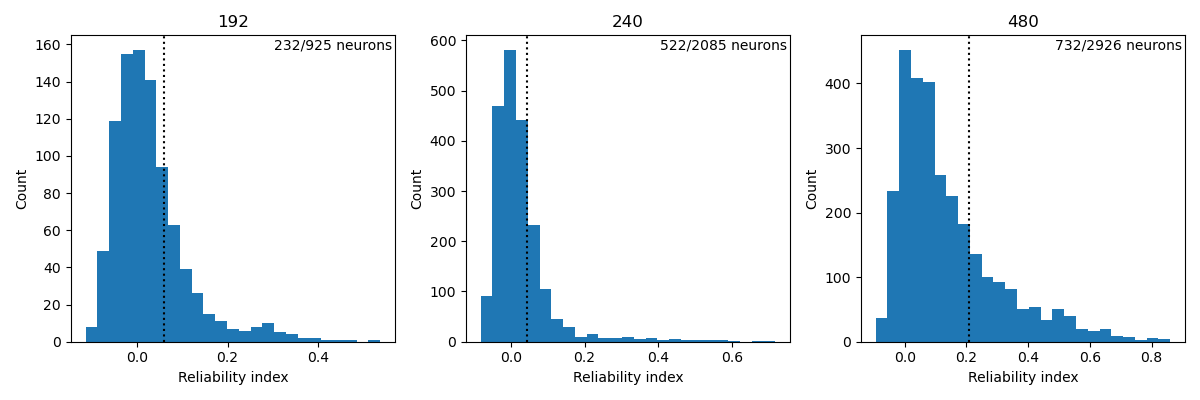

In [166]:
percentile = 75
rel_thrs = {}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, size in enumerate(sizes):
    axes[i].hist(data_dict[size]['pooled_rel_idxs'], bins=25)
    
    rel_thrs[size] = np.percentile(data_dict[size]['pooled_rel_idxs'], percentile)
    axes[i].axvline(rel_thrs[size], c='black', ls=':')
    axes[i].text(.99, .99, '{}/{} neurons'.format((data_dict[size]['pooled_rel_idxs']>=rel_thrs[size]).sum(), data_dict[size]['pooled_rel_idxs'].shape[0]), transform=axes[i].transAxes, va='top', ha='right')    
    
    axes[i].set_xlabel('Reliability index')
    axes[i].set_ylabel('Count')
    axes[i].set_title(size)
    
plt.tight_layout()

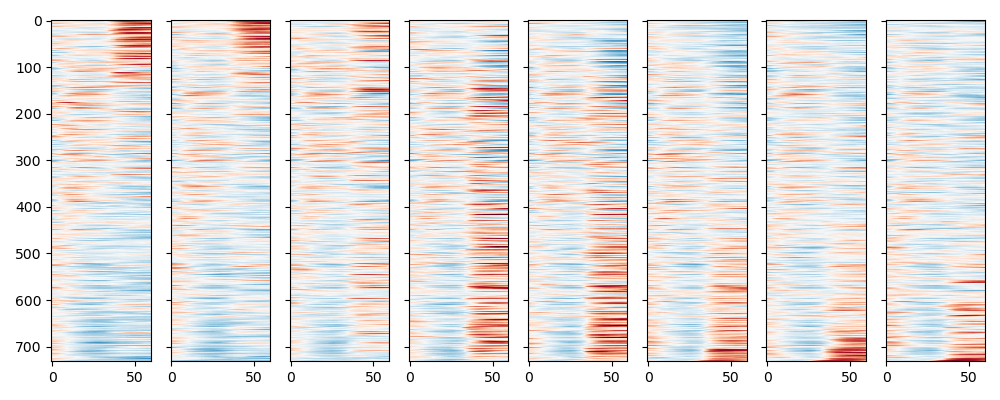

In [225]:
n_dirs = 8

for size in [480]: #sizes:
    traces = data_dict[size]['pooled_trial_traces'][data_dict[size]['pooled_rel_idxs']>=rel_thrs[size], :, :]
    avg_traces = np.nanmean(traces, 1)
    
    com = avg_traces.shape[1]*((np.arange(avg_traces.shape[1])*avg_traces).mean(1))
    ordered_idx = np.argsort(com)
    
#     fig, ax = plt.subplots()
#     ax.imshow(avg_traces[ordered_idx], cmap='RdBu_r', vmin=-2, vmax=2)
#     ax.set_title(size)
    
    fig, axes = plt.subplots(1, n_dirs, sharey=True, figsize=(10, 4))
    
    for i, arr in zip(range(n_dirs), np.split(avg_traces, n_dirs, 1)):
        axes[i].imshow(arr[ordered_idx], cmap='RdBu_r', vmin=-2, vmax=2, aspect='auto')
    
    plt.tight_layout()

In [226]:
fig.savefig(master / 'habenula_480_sorted_example_traces.pdf')